<a href="https://colab.research.google.com/github/Abhinand-p/Fingerprint-Generation/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import cv2
from skimage.color import rgb2gray  # Assuming images are RGB
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [ ]:
CHUNK_SIZE = 40960
DOWNLOAD_DIRECTORY = 'kaggle'  # Specify the directory path where you want to save the data
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F38300%2F58521%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240313%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240313T082420Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D20a65c691485854b0a3c2986fb97ab1596b353d6dc038cf1b6a92602dbf80589afa4322a4c064ad3572abed6e68eec5048b7152ca868eb346a265b58d2e565772584407afc9c7b6ac971f9191ec7d0716f8b2a7800fdca33eecb9d11254dd264547ad24245192002887828a25f6307a8dc307af6a1f28b113ae73cb260ca4b4a09abef00a89ae4fb629b8ac8b74bf7d0bb751dad02402e5f0e57e819a51055dd2f7e8bc5052b66ad48ea1cd1c486ba1b942c88d5f709f479eff820c9e3aa6e63d90d556647e535113201eb15d5375d873ea428e4576dc61a508906aeb1cd2ca16a9e84824a62b18beda260fff9011c998f0dd13192f714f51f0e6f242350f7f6'

# Create the directory if it doesn't exist
os.makedirs(DOWNLOAD_DIRECTORY, exist_ok=True)

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(DOWNLOAD_DIRECTORY, directory)

    os.makedirs(destination_path, exist_ok=True)

    with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
        total_length = fileres.headers['content-length']
        print(f'Downloading {directory}, {total_length} bytes compressed')
        dl = 0
        data = fileres.read(CHUNK_SIZE)
        while len(data) > 0:
            dl += len(data)
            tfile.write(data)
            done = int(50 * dl / int(total_length))
            sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
            sys.stdout.flush()
            data = fileres.read(CHUNK_SIZE)
        with ZipFile(tfile) as zfile:
          zfile.extractall(destination_path)
        print(f'\nDownloaded and uncompressed: {directory}')

print('Data source import complete.')


[==================================================] 878317980 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [ ]:
print(len(os.listdir('kaggle/SOCOFing/Real')))

6000


In [ ]:
def normalize_image(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = rgb2gray(image)
  return (image - np.min(image)) / (np.max(image) - np.min(image))

def process_folder(folder_path, output_path=None):
  for filename in os.listdir(folder_path):
    if filename.endswith(".BMP"):
      image_path = os.path.join(folder_path, filename)
      image = cv2.imread(image_path)
      normalized_image = normalize_image(image)

      if output_path:
        save_path = os.path.join(output_path, filename)
        cv2.imwrite(save_path, normalized_image * 255)
      else:
        cv2.imwrite(image_path, normalized_image * 255)


In [ ]:
data_path = os.path.join('kaggle', 'SOCOFing', 'Real')
output_path = os.path.join('kaggle', 'normalized_socofing', 'Real')

os.makedirs(output_path, exist_ok=True)
process_folder(data_path, output_path)


In [ ]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

dataroot = "kaggle/normalized_socofing"
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5

In [ ]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, inp):
        return self.main(inp)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, inp):
        return self.main(inp)


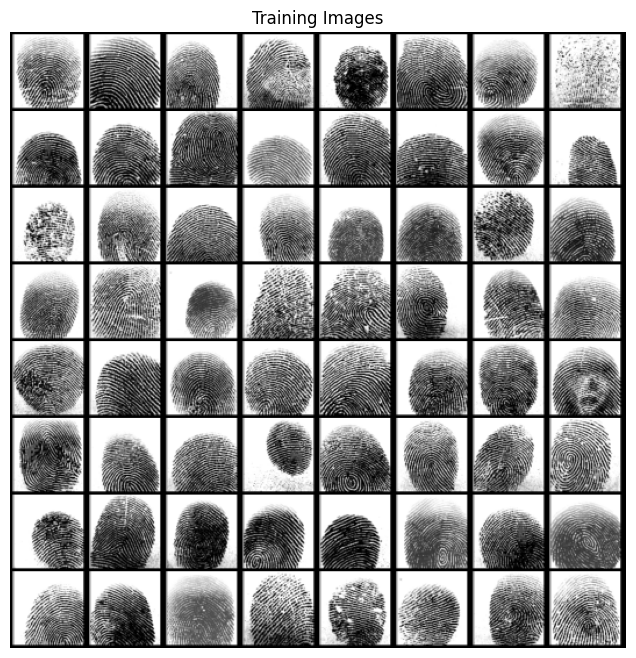

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
dataset = dset.ImageFolder(root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
shuffle=True, num_workers=2)

device = torch.device("cuda")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,
normalize=True).cpu(),(1,2,0)))
plt.show()

generator = Generator().to(device)
generator.apply(init_weights)
print(generator)

discriminator = Discriminator().to(device)
discriminator.apply(init_weights)
print(discriminator)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG= optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))



In [ ]:

# Training loop

img = []
G_loss = []
D_loss = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        discriminator.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        output = discriminator(real_cpu).view(-1)

        errD_real = criterion(output, label.float())
        errD_real.backward()
        D_x = output.mean().item()

        # prepare a batch of random data for the latent space
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # generate batch of fake images
        fake = generator(noise)
        label.fill_(fake_label)

        output = discriminator(fake.detach()).view(-1)

        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()

        # prepare a batch of random data for the latent space
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # generate batch of fake images
        fake = generator(noise)

        generator.zero_grad()
        label.fill_(real_label)

        output = discriminator(fake).view(-1)

        errG = criterion(output, label.float())
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 25 == 0:
            print('Epoch [%d/%d] Batch [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'% (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_loss.append(errG.item())
        D_loss.append(errD.item())

        if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

im_tens = fake[0]
vutils.save_image(im_tens, f"gen_{iters}.bmp")


Epoch [0/100] Batch [0/47]	Loss_D: 1.8048	Loss_G: 3.0636	D(x): 0.3951	D(G(z)): 0.4522 / 0.0705
Epoch [0/100] Batch [25/47]	Loss_D: 0.0643	Loss_G: 14.3560	D(x): 0.9711	D(G(z)): 0.0000 / 0.0000
Epoch [1/100] Batch [0/47]	Loss_D: 0.7014	Loss_G: 7.9633	D(x): 0.8863	D(G(z)): 0.2673 / 0.0013
Epoch [1/100] Batch [25/47]	Loss_D: 2.1799	Loss_G: 1.5869	D(x): 0.2462	D(G(z)): 0.0384 / 0.2685
Epoch [2/100] Batch [0/47]	Loss_D: 1.1190	Loss_G: 3.9912	D(x): 0.6902	D(G(z)): 0.4681 / 0.0238
Epoch [2/100] Batch [25/47]	Loss_D: 1.3198	Loss_G: 5.7970	D(x): 0.8797	D(G(z)): 0.6613 / 0.0044
Epoch [3/100] Batch [0/47]	Loss_D: 1.1797	Loss_G: 0.8581	D(x): 0.3867	D(G(z)): 0.0445 / 0.4551
Epoch [3/100] Batch [25/47]	Loss_D: 0.7460	Loss_G: 2.9342	D(x): 0.6608	D(G(z)): 0.1950 / 0.0768
Epoch [4/100] Batch [0/47]	Loss_D: 0.8615	Loss_G: 5.8991	D(x): 0.9064	D(G(z)): 0.4999 / 0.0057
Epoch [4/100] Batch [25/47]	Loss_D: 1.0575	Loss_G: 7.6220	D(x): 0.9308	D(G(z)): 0.5910 / 0.0010
Epoch [5/100] Batch [0/47]	Loss_D: 0.5512	Lo

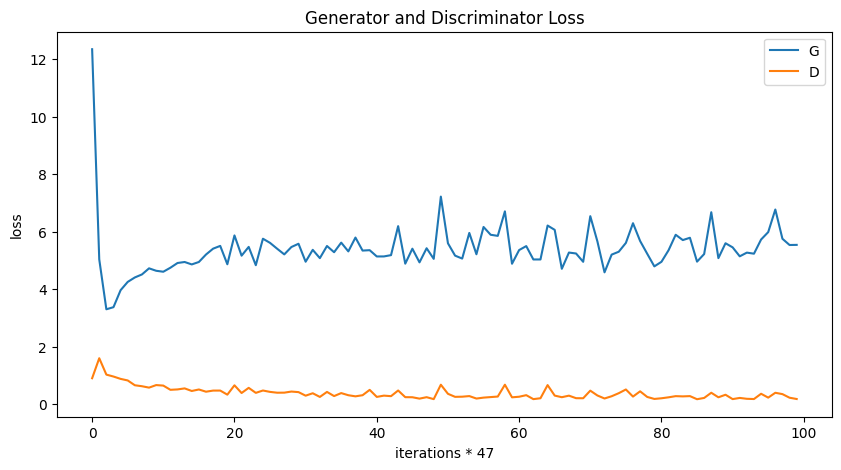

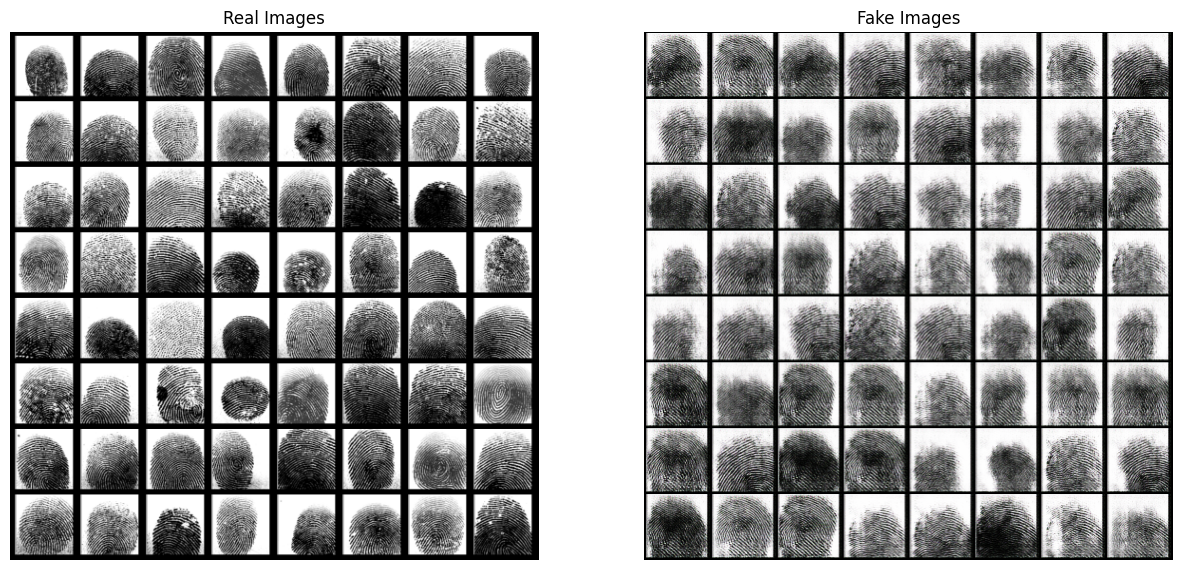

In [ ]:

# plot loss over time
# Get the total number of iterations
num_iterations = len(G_loss)

# Define the number of points to plot (100 in this case)
num_plot_points = 100

# Calculate the interval between plotted points
plot_interval = int(num_iterations / num_plot_points)

# Create lists to store averaged losses
avg_G_loss = []
avg_D_loss = []

# Loop through the loss lists with the calculated interval
for i in range(0, num_iterations, plot_interval):
  # Calculate the average loss for the current interval for each list
  avg_G_loss.append(np.mean(G_loss[i:i+plot_interval]))
  avg_D_loss.append(np.mean(D_loss[i:i+plot_interval]))

# Rest of the plotting code remains the same
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(avg_G_loss, label='G')
plt.plot(avg_D_loss, label='D')
plt.xlabel(f'iterations * {plot_interval}')
plt.ylabel('loss')
plt.legend()
plt.show()
print('\n\n')

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img[-1],(1,2,0)))
plt.show()

# save the optimizer and discriminator state for the demo
torch.save(
    {
        'discriminator_state_dict':discriminator.state_dict(),
        'optimizerD_state_dict':optimizerD.state_dict(),
        'generator_state_dict':generator.state_dict(),
        'optimizerG_state_dict':optimizerG.state_dict()
    },
    'networkStates.pyt'
)